# Trabalho Prático 1 - ALG2
Matheus Grandinetti Barbosa Lima - 2021067496


## Introdução

Para melhor explicação dos algoritmos e dos passos necessários para a criação dos modelos, o trabalho será divido em 5 principais partes:

*   Primitivas
*   Envoltória convexa
*   Separabilidade linear
*   Ponto médio entre envoltórias
*   Criação e análise dos modelos







## Primitivas

Como forma de representar pontos e segmentos, as seguintes classes básicas foram criadas:

In [2]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def print_coordinates(self):
        print(f'({self.x},{self.y})')

Além disso, foram utilizadas algumas primitivas auxiliares, separadas na classe Tools:

In [3]:
class Tools:
    def find_orientation(p1: Point, p2: Point, p3: Point):
        cross_product = (p2.y - p1.y) * (p3.x - p2.x) - (p2.x - p1.x) * (p3.y - p2.y)

        if cross_product == 0:
            return 0
        elif cross_product > 0:
            return 1
        else:
            return -1

    def point_to_list(set: [Point]):
      x_list = [point.x for point in set]
      y_list = [point.y for point in set]

      return (x_list, y_list)

Definindo essa base de código, podemos começar a resolver o problema proposto.

## Envoltória Convexa

Para resolver a problemática da envoltória convexa, utilizamos o algoritmo de Jarvis, conhecido também como Gift Wrap. Funções auxiliares foram criadas com o objetivo de facilitar a manutenção e visualização dos resultados obtidos dentro da classe ConvexHull.

In [4]:
class ConvexHull:
    def __init__(self, point_set):
        self.point_set = point_set
        self.hull = []
        self.tools = Tools

    def print_point_set(self):
        for point in self.point_set:
            point.print_coordinates()

    def find_point_index(self, p):
        index = 0

        for point in self.point_set:
            if p.x == point.x and p.y == point.y:
                return index
            index += 1

    def find_ancor(self):
        ancor = self.point_set[0]

        for point in self.point_set:
            if point.x < ancor.x:
                ancor = point

        return ancor

    def find_next_ancor(self, p, q):
        for point in self.point_set:
            if self.tools.find_orientation(p,q,point) == 1:
                q = point

        return q

    def find_convex_hull(self):
        set_size = len(self.point_set)

        ancor = self.find_ancor()
        self.hull.append(ancor)
        next = self.point_set[(self.find_point_index(ancor)+1)%set_size]

        current = self.find_next_ancor(ancor, next)

        while True:
            self.hull.append(current)
            next = self.point_set[(self.find_point_index(current)+1)%set_size]
            current = self.find_next_ancor(current, next)

            if current.x == self.hull[0].x and current.y == self.hull[0].y:
                break

        return self.hull

    def print_convex_hull(self):
        for point in self.hull:
            point.print_coordinates()

    def clean_current_hull(self):
        self.hull = []

Vamos começar plotando um conjunto de pontos cuja envoltória convexa é facilmente identificada:

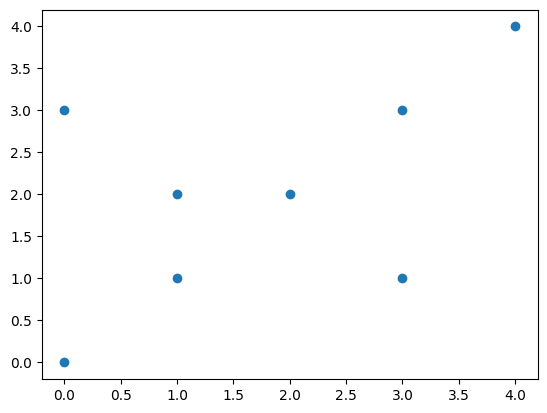

In [5]:
import matplotlib.pyplot as plt

point_set = []

point_set.append(Point(0,3))
point_set.append(Point(0,0))
point_set.append(Point(1,1))
point_set.append(Point(2,2))
point_set.append(Point(3,3))
point_set.append(Point(4,4))
point_set.append(Point(3,1))
point_set.append(Point(1,2))

array_point_set = Tools.point_to_list(set=point_set)

plt.scatter(x=array_point_set[0],y=array_point_set[1])
plt.show()

Utilizando a função *find_convex_hull*, obtemos os pontos que fazem parte da envoltória, temos portanto:

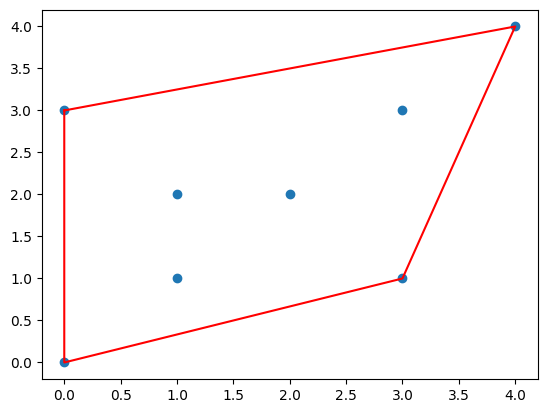

In [6]:
hull = ConvexHull(point_set)
hull_points = hull.find_convex_hull()
hull_points_array = Tools.point_to_list(set=hull_points)
hull_points_array[0].append(hull_points[0].x)
hull_points_array[1].append(hull_points[0].y)

plt.plot(hull_points_array[0],hull_points_array[1], color="red")
plt.scatter(x=array_point_set[0],y=array_point_set[1])
plt.show()

Podemos observar a corretude do código utilizando pontos aleatórios. No exemplo abaixo foram gerados 50 pontos:

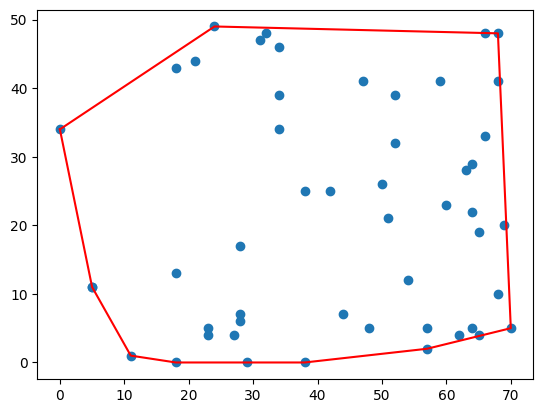

In [7]:
from random import randint

random_point_set = []
for x in range(0,50):
  random_point_set.append(Point(randint(0,70),randint(0,50)))

new_array_point_set = Tools.point_to_list(set=random_point_set)

plt.scatter(x=new_array_point_set[0],y=new_array_point_set[1])

new_hull = ConvexHull(random_point_set)
new_hull_points = new_hull.find_convex_hull()
new_hull_points_array = Tools.point_to_list(set=new_hull_points)
new_hull_points_array[0].append(new_hull_points[0].x)
new_hull_points_array[1].append(new_hull_points[0].y)

plt.plot(new_hull_points_array[0],new_hull_points_array[1], color="red")
plt.show()


## Separabilidade Linear

## Ponto médio entre envoltórias

## Criação e análise de modelos

In [75]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA

### Iris dataset

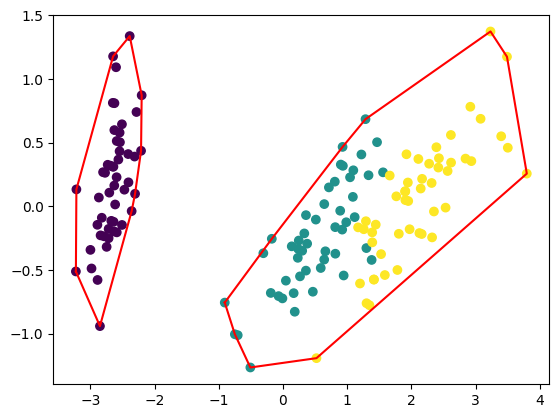

In [76]:
iris = datasets.load_iris()
iris_reduced_points = PCA(n_components=2).fit_transform(iris.data)

sitosa_set =  []
non_sitosa_set = []

iris_index = 0
for x in iris.target:
    if x == 0:
        sitosa_set.append(Point(iris_reduced_points[iris_index][0], iris_reduced_points[iris_index][1]))
    else:
        non_sitosa_set.append(Point(iris_reduced_points[iris_index][0], iris_reduced_points[iris_index][1]))
    iris_index += 1

sitosa_hull = ConvexHull(sitosa_set)
sitosa_hull_points = sitosa_hull.find_convex_hull()
sitosa_hull_points_array = Tools.point_to_list(set=sitosa_hull_points)
sitosa_hull_points_array[0].append(sitosa_hull_points[0].x)
sitosa_hull_points_array[1].append(sitosa_hull_points[0].y)

non_sitosa_hull = ConvexHull(non_sitosa_set)
non_sitosa_hull_points = non_sitosa_hull.find_convex_hull()
non_sitosa_hull_points_array = Tools.point_to_list(set=non_sitosa_hull_points)
non_sitosa_hull_points_array[0].append(non_sitosa_hull_points[0].x)
non_sitosa_hull_points_array[1].append(non_sitosa_hull_points[0].y)

plt.scatter(x=iris_reduced_points[:, 0], y=iris_reduced_points[:, 1], c=iris.target)
plt.plot(sitosa_hull_points_array[0],sitosa_hull_points_array[1], color="red")
plt.plot(non_sitosa_hull_points_array[0],non_sitosa_hull_points_array[1], color="red")
plt.show()


### Breast cancer dataset

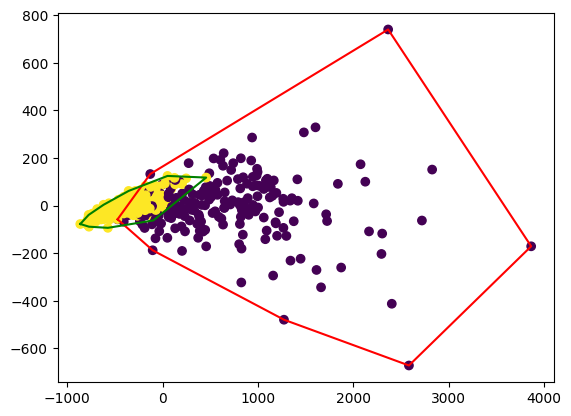

In [9]:
breast_cancer = datasets.load_breast_cancer()
breast_cancer_reduced_points = PCA(n_components=2).fit_transform(breast_cancer.data)

malignant_set = []
benign_set = []

breast_cancer_index = 0
for x in breast_cancer.target:
    if x == 0:
        malignant_set.append(
            Point(
                breast_cancer_reduced_points[breast_cancer_index][0], 
                breast_cancer_reduced_points[breast_cancer_index][1]
            )
        )
    else:
        benign_set.append(
            Point(
                breast_cancer_reduced_points[breast_cancer_index][0], 
                breast_cancer_reduced_points[breast_cancer_index][1]
            )
        )
    breast_cancer_index+=1

malignant_hull = ConvexHull(malignant_set)
malignant_hull_points = malignant_hull.find_convex_hull()
malignant_hull_points_array = Tools.point_to_list(set=malignant_hull_points)
malignant_hull_points_array[0].append(malignant_hull_points[0].x)
malignant_hull_points_array[1].append(malignant_hull_points[0].y)

benign_hull = ConvexHull(benign_set)
benign_hull_points = benign_hull.find_convex_hull()
benign_hull_points_array = Tools.point_to_list(set=benign_hull_points)
benign_hull_points_array[0].append(benign_hull_points[0].x)
benign_hull_points_array[1].append(benign_hull_points[0].y)

plt.scatter(x=breast_cancer_reduced_points[:, 0], y=breast_cancer_reduced_points[:, 1], c=breast_cancer.target)
plt.plot(malignant_hull_points_array[0],malignant_hull_points_array[1], color="red")
plt.plot(benign_hull_points_array[0],benign_hull_points_array[1], color="green")
plt.show()


### Banana dataset

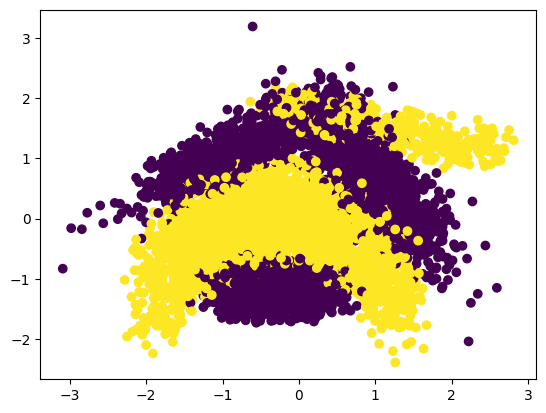

In [24]:
banana_df = pd.read_csv('datasets/banana_prepared.csv')
banana_df

plt.scatter(x=banana_df['At1'],y=banana_df['At2'], c=banana_df['Class'])
plt.show()

### Segment dataset

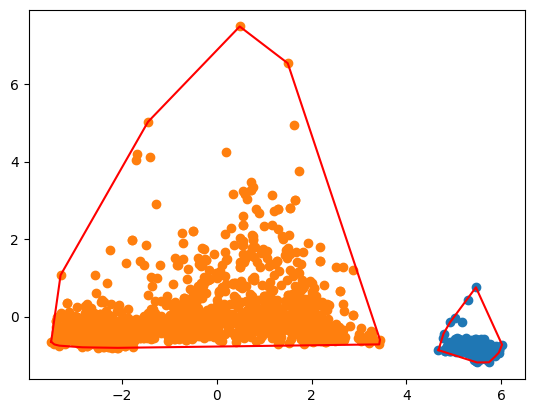

In [74]:
segments_df = pd.read_csv('datasets/segments.csv')
segments_colors = segments_df['Class']
segments_df.drop(columns='Class', inplace=True)

segments_reduced = PCA(n_components=2).fit_transform(segments_df)

class_2 = []
other_classes = []

index = 0
for color in segments_colors:
    if color == 2:
        class_2.append(segments_reduced[index])
    elif color != 2 and color != 3:
        other_classes.append(segments_reduced[index])
    index+=1

class_2 = np.array(class_2)
other_classes = np.array(other_classes)

class_2_point_set = []
other_point_set = []

for point in class_2:
    class_2_point_set.append(Point(point[0],point[1]))
for point in other_classes:
    other_point_set.append(Point(point[0],point[1]))
    
class2_hull = ConvexHull(class_2_point_set)
class2_hull_points = class2_hull.find_convex_hull()
class2_hull_points_arr = Tools.point_to_list(class2_hull_points)
class2_hull_points_arr[0].append(class2_hull_points[0].x)
class2_hull_points_arr[1].append(class2_hull_points[0].y)

other_hull = ConvexHull(other_point_set)
other_hull_points = other_hull.find_convex_hull()
other_hull_points_arr = Tools.point_to_list(other_hull_points)
other_hull_points_arr[0].append(other_hull_points[0].x)
other_hull_points_arr[1].append(other_hull_points[0].y)

plt.scatter(class_2[:,0], class_2[:,1])
plt.scatter(other_classes[:,0], other_classes[:,1])

plt.plot(class2_hull_points_arr[0],class2_hull_points_arr[1], color="red")
plt.plot(other_hull_points_arr[0],other_hull_points_arr[1], color="red")

plt.show()

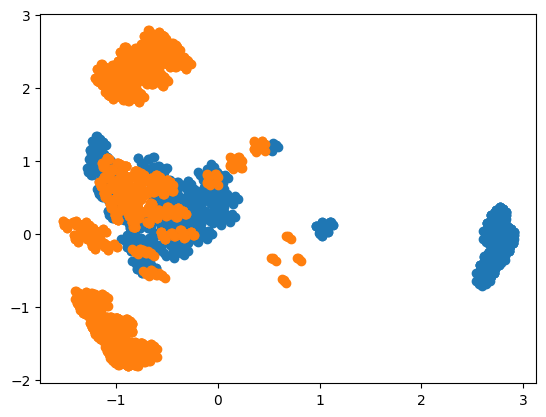

In [90]:
mushroom_df = pd.read_csv('datasets/mushroom.csv')
mushroom_df.head()

mushroom_type = mushroom_df['Class']
mushroom_df.drop(columns=['Class'], inplace=True)

mushroom_reduced = PCA(n_components=2).fit_transform(mushroom_df)

index=0
p_mushroom = []
e_mushroom = []
for mushroom in mushroom_type:
    if mushroom == 'p':
        p_mushroom.append(mushroom_reduced[index])
    else:
        e_mushroom.append(mushroom_reduced[index])
    index+=1

p_mushroom_arr = np.array(p_mushroom)
e_mushroom_arr = np.array(e_mushroom)

plt.scatter(p_mushroom_arr[:,0],p_mushroom_arr[:,1])
plt.scatter(e_mushroom_arr[:,0], e_mushroom_arr[:,1])
plt.show()
        